# TI3130: Unsupervised Learning &mdash; Exercises
**Julián Urbano and Jing Sun &mdash; January 2024**

In [13]:
import sys
import numpy as np
import pandas as pd
from plotnine import *
from plotnine import __version__ as p9__version__
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import __version__ as sk__version__

print("python", sys.version,
      "\nnumpy", np.__version__,
      "\npandas", pd.__version__,
      "\nplotnine", p9__version__,
      "\nstatsmodels", sm.__version__,
      "\nsklearn", sk__version__)

# sklearn 1.3.0 gives a number of warnings informing about API changes
# we'll supress them because they'll clutter too much the notebook
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

python 3.11.5 (tags/v3.11.5:cce6ba9, Aug 24 2023, 14:38:34) [MSC v.1936 64 bit (AMD64)] 
numpy 1.26.1 
pandas 2.1.3 
plotnine 0.12.4 
statsmodels 0.14.0 
sklearn 1.3.2


For these exercises we will use the _Amsterdam Lite_, _Heart_, _Arrests_ and _Whiskey_ datasets. Please refer to their HTML files for a description of the variables.

In [14]:
def obj2cat(df):
    for col in df.select_dtypes('object').columns:
        df[col] = pd.Categorical(df[col])
    return df

ams = obj2cat(pd.read_csv('amsterdam_lite.csv'))
heart = obj2cat(pd.read_csv('heart.csv'))
arrests = obj2cat(pd.read_csv('arrests.csv'))
whiskey = obj2cat(pd.read_csv('whiskey.csv'))

We will also use the evaluation metrics and cross-validation code we used in the _Classification_ tutorial, as well as the visualization functions we used in the _Unsupervised Learning_ tutorial:

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
# to display confusion matrices in the notebook
%matplotlib inline
from sklearn.model_selection import StratifiedKFold

def kfold_cv(X, y, k, H, cv_fun, random_state):
    """
    Do stratified k-fold cross-validation with a dataset, to check how a model behaves as a function
    of the values in H (eg. a hyperparameter such as tree depth, or polynomial degree).

    :param X: feature matrix.
    :param y: response column.
    :param k: number of folds.
    :param H: values of the hyperparameter to cross-validate.
    :param cv_fun: function of the form (X_train, y_train, X_valid, y_valid, h) to evaluate the model in one split,
        as a function of h. It must return a dictionary with metric score values.
    :param random_state: controls the pseudo random number generation for splitting the data.
    :return: a Pandas dataframe with metric scores along values in H.
    """
    kf = StratifiedKFold(n_splits = k, shuffle = True, random_state = random_state)
    scores = []  # to store global results

    # for each value h in H, do CV
    for h in H:
        
        # for each fold 1..K
        kk = 0
        for train_index, valid_index in kf.split(X, y):
            kk = kk+1
            # partition the data in training and validation
            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

            # call cv_fun to train the model and compute performance
            fold_scores = {'_h': h, '_fold': kk}
            fold_scores.update(cv_fun(X_train, y_train, X_valid, y_valid, h))
            scores.append(fold_scores)
            
    return pd.DataFrame(scores)
            
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

def plot_dendrogram(X, labels=None, figsize=(14,6), **kwargs):
    model = AgglomerativeClustering(compute_full_tree = True, compute_distances = True).fit(X)
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    plt.figure(figsize=(14,6))
    dendrogram(linkage_matrix, color_threshold = 0, leaf_rotation = 90, labels=labels, **kwargs)
    
    res.append(fold_scores)
            
    return pd.DataFrame(scores)

def pca_summary(pca_model):
    sdev = np.sqrt(pca_model.explained_variance_)
    var_cor = np.apply_along_axis(lambda c: c*sdev, 0, pca_model.components_)
    var_cos2 = var_cor**2
    comp_cos2 = np.sum(var_cos2, 1)
    var_contrib = np.apply_along_axis(lambda c: c/comp_cos2, 0, var_cos2)
    return var_cor, var_contrib

def pca_screeplot(pca_model, figsize=(5,3)):
    """
    Shows a barplot of the fraction of variance explained by each PC.
    """
    var_cor, var_contrib = pca_summary(pca_model)
    dim = np.arange(var_cor.shape[1])
    var = pca_model.explained_variance_ratio_

    plt.figure(figsize=figsize)
    plt.rc('axes', axisbelow=True)
    plt.grid(axis = 'y', linewidth = 0.5)
    plt.bar(dim, 100*var)
    plt.xticks(dim, dim+1)
    plt.xlabel('Component')
    plt.ylabel('Explained variance (%)')
    plt.title('Scree plot')
    plt.tight_layout()

def pca_corplot(pca_model, column_names, comp = [0,1], figsize=(5,5)):
    """
    Shows the variables in a correlation circle.
    The projection of each variable on a PC represents its correlation with that PC.
    """
    var_cor, var_contrib = pca_summary(pca_model)
    
    plt.figure(figsize=figsize)
    plt.rc('axes', axisbelow=True)
    plt.grid(linewidth = 0.5)
    plt.axhline(linestyle='--', color='k')
    plt.axvline(linestyle='--', color='k')
    plt.gcf().gca().add_patch(plt.Circle((0,0),1,color='grey',fill=False))
    plt.xlim([-1.1,1.1])
    plt.ylim([-1.1,1.1])
    plt.xlabel(f'PC{comp[0]+1}')
    plt.ylabel(f'PC{comp[1]+1}')
    plt.title(f'Correlation circle PC{comp[0]+1}-PC{comp[1]+1}')
    plt.tight_layout()

    for i in range(pca_model.n_components_):
        x = var_cor[comp[0],i]
        y = var_cor[comp[1],i]
        plt.arrow(0,0,x,y, color='k',
                 head_length=.025, head_width=.025, length_includes_head=True)
        plt.text(x,y,
                 horizontalalignment='left' if x>0 else 'right',
                 verticalalignment='bottom' if y>0 else 'top',
                 color='k', s=list(column_names)[i])

def pca_contribplot(pca_model, column_names, comp = 0, figsize=(6,5)):
    """
    Shows a barplot of the contribution of each variable to a PC.
    """
    var_cor, var_contrib = pca_summary(pca_model)
    dim = np.arange(var_cor.shape[1])
    i = (-var_contrib[comp]).argsort()

    plt.figure(figsize=figsize)
    plt.rc('axes', axisbelow=True)
    plt.grid(axis = 'y', linewidth = 0.5)
    plt.bar(dim, 100*var_contrib[comp][i])
    plt.axhline(y=100/len(dim), linestyle='--', color='r')
    plt.xticks(dim, column_names[i])
    plt.ylabel('Contribution (%)')
    plt.title(f'Contribution of variables to PC{comp+1}')
    plt.tight_layout()

def pca_biplot(X, pca_model, column_names, comp = [0,1], clusters = None, labels = None, figsize=(10,8)):
    """
    Shows a scatterplot showing each observation in the 2D space defined by two PCs,
    along with the vectors corresponding to each feature.
    Observations can optionally be identified by a label and a color (eg. to identify clusters).
    Adapted from https://jbhender.github.io/Stats506/F17/Projects/G18.html
    """
    xvector = pca_model.components_[comp[0]]
    yvector = pca_model.components_[comp[1]]

    xs = pca_model.transform(X)[:,comp[0]]
    ys = pca_model.transform(X)[:,comp[1]]
        
    plt.figure(figsize=figsize)
    plt.rc('axes', axisbelow=True)
    plt.grid(linewidth = 0.5)
    plt.axhline(linestyle='--', color='k')
    plt.axvline(linestyle='--', color='k')
    plt.xlim([min([0, min(xs), min(xvector*max(xs)*1.1)]),
              max([0, max(xs), max(xvector*max(xs)*1.1)])
             ])
    plt.ylim([min([0, min(ys), min(yvector*max(ys)*1.1)]),
              max([0, max(ys), max(yvector*max(ys)*1.1)])
             ])
    plt.xlabel(f'PC{comp[0]+1}')
    plt.ylabel(f'PC{comp[1]+1}')
    plt.title(f'Biplot PC{comp[0]+1}-PC{comp[1]+1}')
    
    # plot vectors
    for i in range(len(xvector)):
        x = xvector[i]*max(xs)
        y = yvector[i]*max(ys)
        plt.arrow(0, 0, x, y, color='k',
                 head_length=.1, head_width=.1, length_includes_head=True)
        plt.text(x*1.1, y*1.1, color='k', s=list(column_names)[i])

    # plot observations
    if labels is None:
        labels = np.arange(X.shape[0]).astype('str')
    if clusters is None:
        clusters = np.zeros(X.shape[0], dtype=int)
    colors = plt.colormaps['tab10'].colors
    color_map = {}
    for c in np.unique(clusters):
        color_map[c] = len(color_map)
        plt.plot(0,0, color = colors[color_map[c]], label=str(c)) # only to make sure the legend appears
    plt.legend()
    for i in range(len(xs)):
        plt.plot(xs[i], ys[i], color = colors[color_map[clusters[i]]], marker='.')
        plt.text(xs[i], ys[i], color = colors[color_map[clusters[i]]], label=str(clusters[i]),
                 s = labels[i], ha='center', va='top' if ys[i]>0 else 'bottom')

**1) Train a PCA model on all three criminality variables (ie. `murder`, `rape` and `assault`) of the _Arrests_ dataset. Visualize the model with function `pca_biplot`. Which appear to be the 3 most dangerous states?**

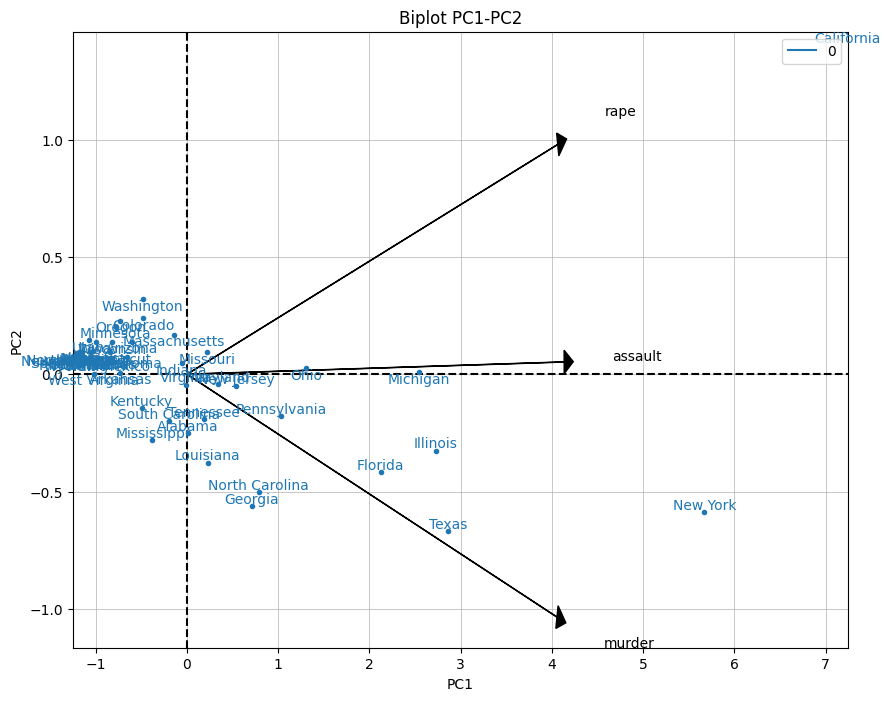

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = arrests[['murder', 'rape', 'assault']]
X_scaled = StandardScaler().fit(X).transform(X)
g = PCA().fit(X_scaled)
pca_biplot(X_scaled, g, X.columns.values, labels=arrests['state'])

# The 3 most dangerous states appear to be New York, Texas and Illinois,
# because these states score high along PC1, which all three criminality variables seem to be about.

**2) Do the same as in 1), but use rates per population instead of counts (ie. `murder/population` instead of `murder`). Visualize the model and find out the 3 most dangerous states. Why are the results different? Note that, in a sense, using rates is similar to standardizing.**

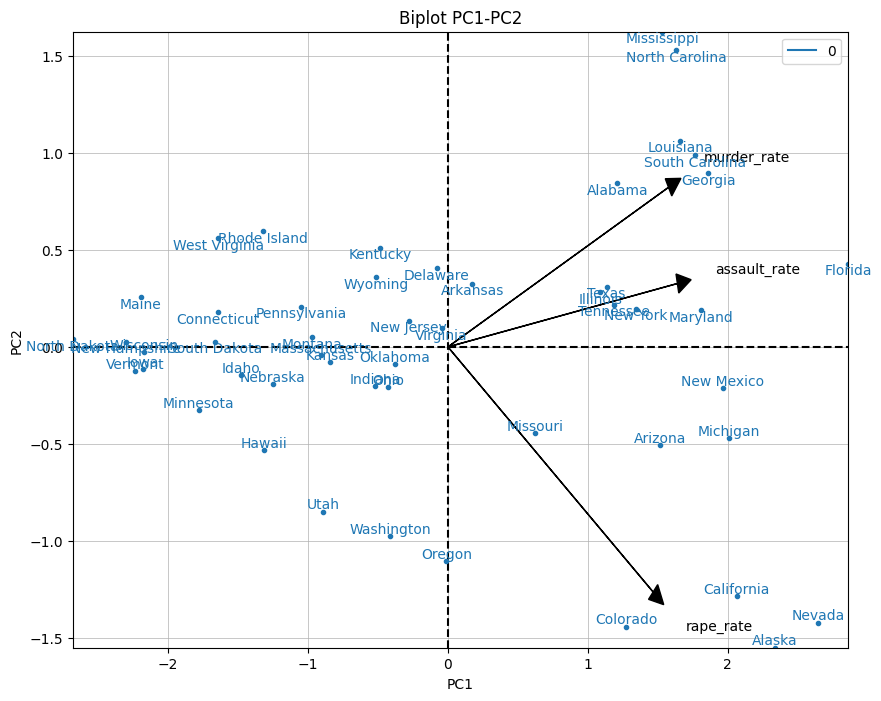

In [19]:
arrests = arrests \
    .assign(murder_rate = arrests.murder / arrests.population,
            rape_rate = arrests.rape / arrests.population,
            assault_rate = arrests.assault / arrests.population)

X = arrests[['murder_rate', 'rape_rate', 'assault_rate']]
X_scaled = StandardScaler().fit(X).transform(X)
g = PCA().fit(X_scaled)
pca_biplot(X_scaled, g, X.columns.values, labels=arrests['state'])

# 3 most dangerous states now appear to be Florida, Nevada and Alaska.
# Results are different because the variable inerpretation is different:
# in part 1, states with larger population appeared to be more dangerous than they are,
# This plot is more accurate since it uses rates.

**3) Run hierarchical clustering on all numeric variables of the _Heart_ dataset to separate patients in 4 clusters. Fit a decision tree to the same data to predict the clusters, so that we may try and interpret them. What 2 variables seem to be the most important in defining the clusters? You don't need to create an image of the tree; you can simply use [`tree.export_text`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_text.html) (refer back to the _Classification_ tutorial for reference).**

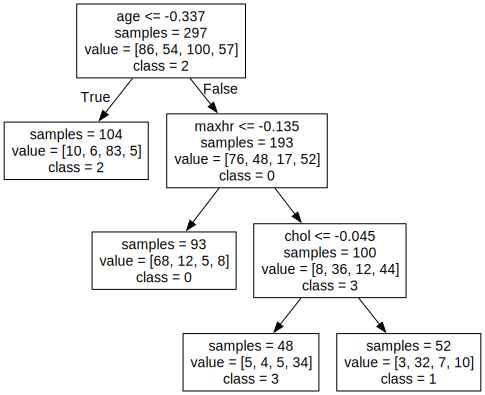

In [27]:
from sklearn.cluster import AgglomerativeClustering
from sklearn import tree
import graphviz

X = heart.select_dtypes('number')
X_scaled = StandardScaler().fit(X).transform(X)
m = AgglomerativeClustering(n_clusters = 4).fit(X_scaled)
heart['_y'] = pd.Categorical(m.labels_.astype('str'))
y = heart['_y']
m_tree = tree.DecisionTreeClassifier(max_leaf_nodes=4, random_state = 12345).fit(X_scaled, y)
tree.export_text(m_tree)
dot_data = tree.export_graphviz(m_tree, feature_names = X.columns, class_names = y.cat.categories, \
                                impurity = False, node_ids = False)
graphviz.Source(dot_data)

# Most important variables in defining clusters are age and maximum heart rate achieved (maxhr)

**4) The code below generates a synthetic dataset with 300 observations for the classification of two classes based on two features related in a circular manner. An SVM classifier is fitted to these data and its [decision boundary](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html) shows that it is able to correctly separate the two classes. The k-means clustering algorithm is also ran with the same data, but the plot shows that it fails at correctly identifying the two classes. Explain what is the problem of k-means in this case.**

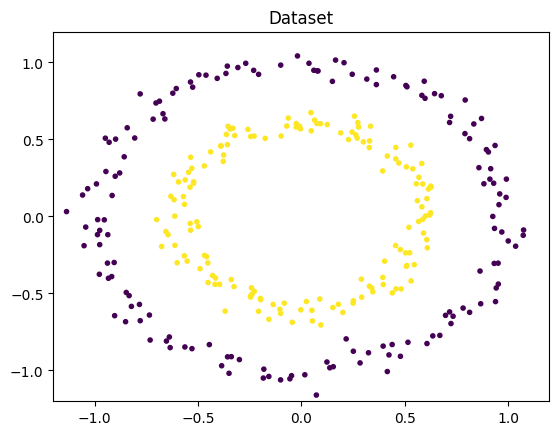

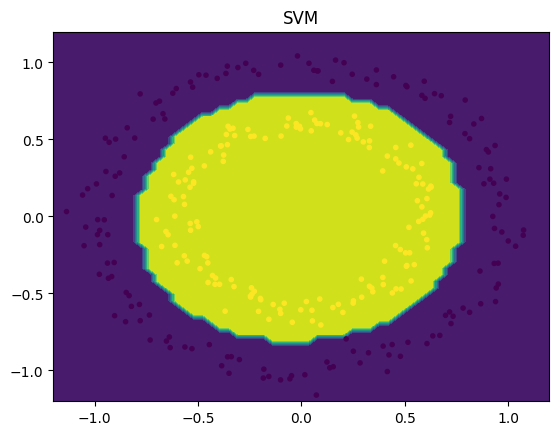

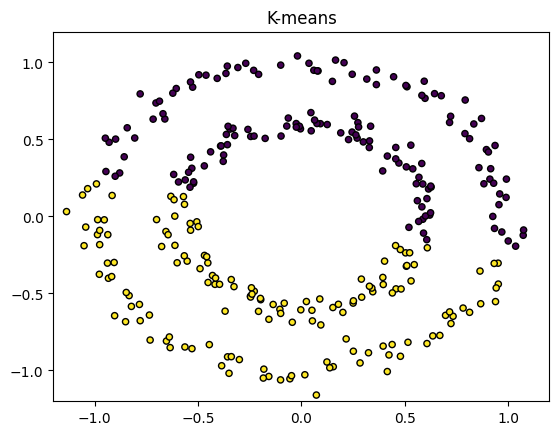

In [31]:
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# generate synthetic dataset and plot
X, y = datasets.make_circles(n_samples=300, noise=0.05, factor=0.6, random_state=123)
plt.scatter(X[:, 0], X[:, 1], c=y, marker='.')
plt.xlim((-1.2,1.2))
plt.ylim((-1.2,1.2))
plt.title('Dataset')
plt.show()

# build SVM classifier and plot decision boundary
m_class = SVC(random_state=123, kernel='rbf').fit(X, y)
DecisionBoundaryDisplay.from_estimator(m_class, X, response_method='predict')
plt.scatter(X[:, 0], X[:, 1], c=y, marker='.')
plt.xlim((-1.2,1.2))
plt.ylim((-1.2,1.2))
plt.title('SVM')
plt.show()

# run k-means and plot
m_clust = KMeans(n_clusters = 2, random_state = 123).fit(X)
plt.scatter(X[:, 0], X[:, 1], c=m_clust.labels_, edgecolor='k', s=20)
plt.xlim((-1.2,1.2))
plt.ylim((-1.2,1.2))
plt.title('K-means')
plt.show()

# K-means clustering is not good at detecting clusters of non linear relationships
# Since K-means try to minimize the sum of squared distances from the cluster centers,
# There are no place where such centers could be placed that would capture
# the ring shaped distribution of the purple datapoints into one cluster.

**5) We want to build a logistic classifier to predict the `ahd` in the _heart_ dataset using all numeric features. We want to use PCA to first simplify the feature space, but we don't know how many principal components to include. Use 10-fold cross-validation to create a plot of F-score by number of principal components.**

C:\Users\EgleS\AppData\Local\Temp\ipykernel_22396\3824709462.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\EgleS\AppData\Local\Temp\ipykernel_22396\3824709462.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\EgleS\AppData\Local\Temp\ipykernel_22396\3824709462.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

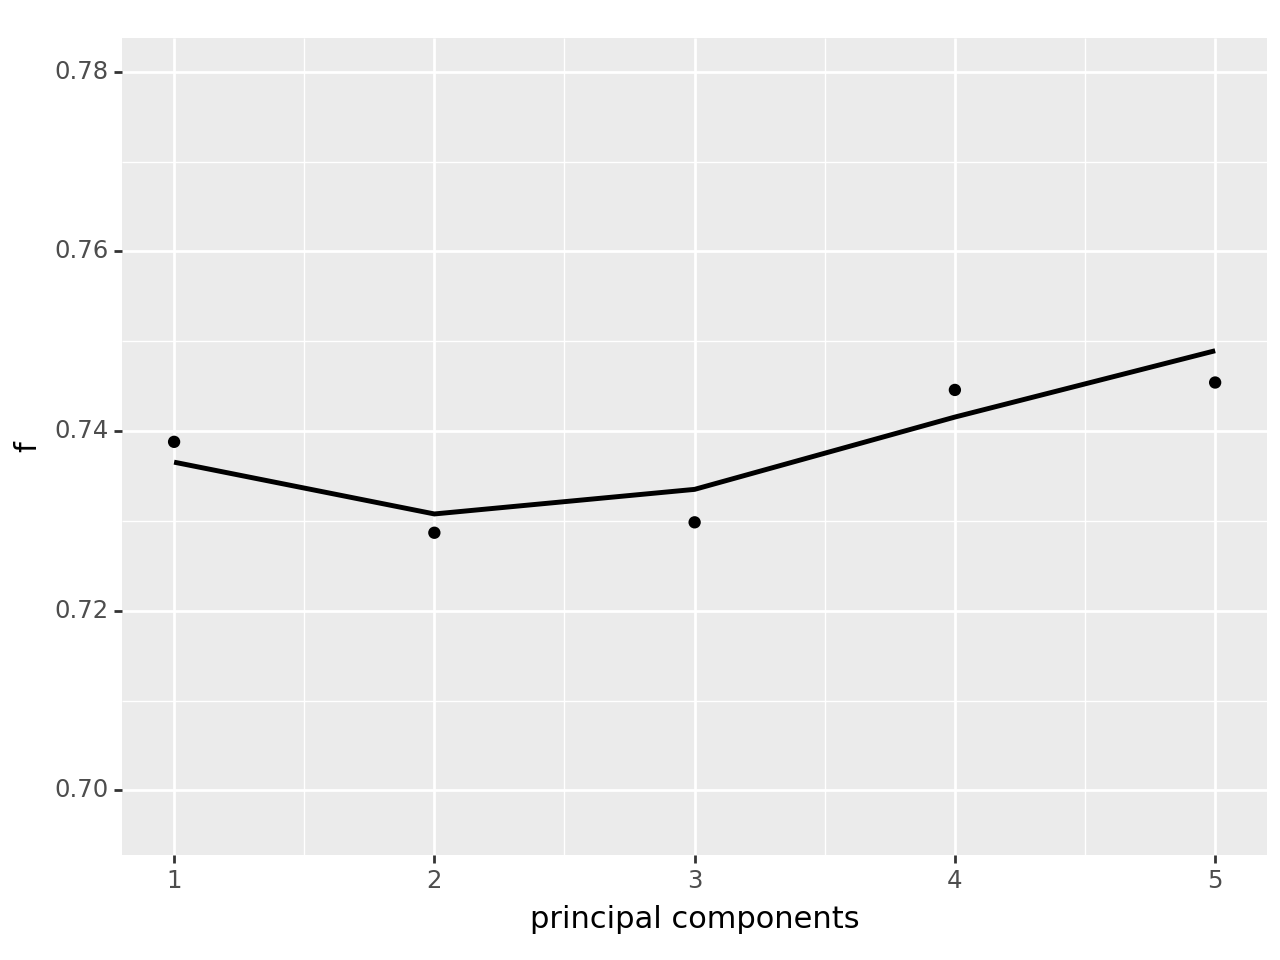

<Figure Size: (640 x 480)>

In [68]:
y = heart['ahd'].cat.codes
X = heart.select_dtypes('number')
X_scaled = StandardScaler().fit(X).transform(X)
g = PCA().fit(X_scaled)
X_star = pd.DataFrame(data = g.transform(X_scaled), columns = ['PC1','PC2','PC3','PC4','PC5','PC6'])
k = 10 # folds
H = range(1, 6) # 6 numeric variables in heart dataset
def cv_fun(X_train, y_train, X_valid, y_valid, h):
    df_train = X_train
    df_train['y'] = y_train
    # add h first principal components
    formula = f'y ~ {" + ".join([f"PC{i}" for i in range(1, h+1)])}'
    f = smf.glm(formula, df_train, family = sm.families.Binomial()).fit()
    p = f.predict(X_valid)
    p = np.where(p < .5, 0, 1)
    return {'accuracy': accuracy_score(y_valid, p),
            'precision': precision_score(y_valid, p, average = 'macro', zero_division = 0),
            'recall': recall_score(y_valid, p, average = 'macro'),
            'f': f1_score(y_valid, p, average = 'macro')}

pr = kfold_cv(X_star, y, k, H, cv_fun, random_state=123)
averaged_pr = pr \
    .groupby('_h') \
    .aggregate({'accuracy': 'mean', \
                'precision': 'mean', \
                'recall': 'mean', \
                'f': 'mean'})

ggplot(pr, aes('_h', 'f')) +\
    stat_summary(geom = 'point') +\
    geom_smooth(se = False) +\
    labs(x = 'principal components')

**6) Create an _unambiguous_ and _nontrivial_ question, and its corresponding solution, as if you were writing the set of exercises for the lab. The question must cover at least 3 of the following aspects:**

- **k-means clustering**
- **Hierarchical clustering**
- **PCA**
- **Choice of hyperparameters**
- **Interpretation or visualization of clusters/PCs**
- **Unsupervised learning to aid in the construction of supervised models**
- **Open-ended conceptual question to explain some behavior**

**Please make it explicit which 3 of these aspects your question covers. You can use any of the datasets available on Brightspace.**

Count of Data Points in Each k-means Cluster:
kmeans_cluster
0    59
2    15
1    12
Name: count, dtype: int64


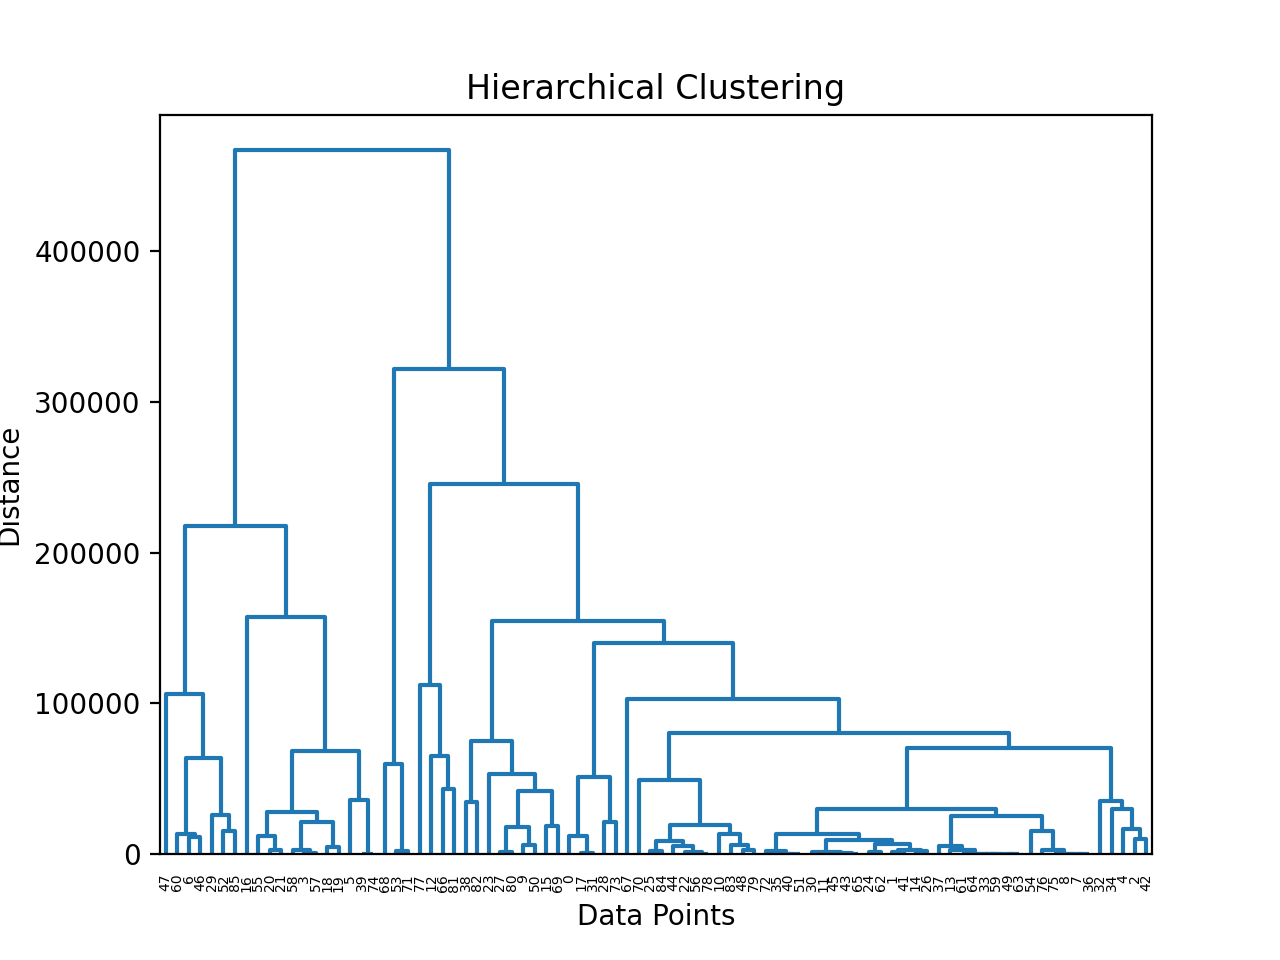

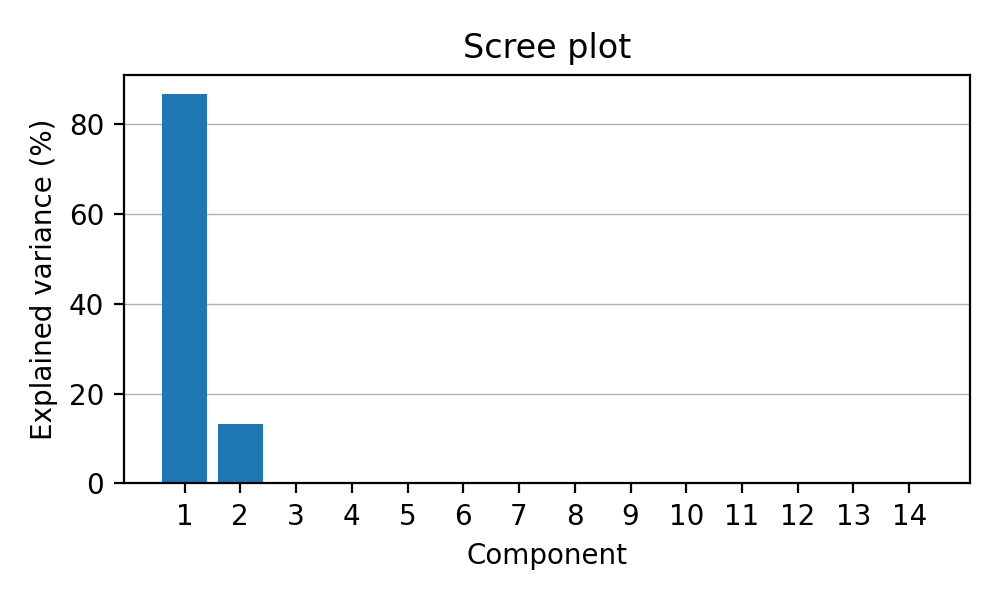

In [69]:
#Consider the 'whiskey.csv' 
#In this question, we will explore the aspects of k-means clustering, hierarchical clustering, and PCA.
# Load the 'whiskey.csv' dataset
whiskey = obj2cat(pd.read_csv('whiskey.csv'))

# Extract numeric columns for clustering
numeric_columns = whiskey.select_dtypes(include=['float64', 'int64']).columns
whiskey_numeric = whiskey[numeric_columns]

# Import necessary libraries
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

# K-means Clustering:
# Use k-means with n_clusters=3 and extract cluster labels.
kmeans = KMeans(n_clusters=3, random_state=42)
whiskey['kmeans_cluster'] = kmeans.fit_predict(whiskey_numeric)
print("Count of Data Points in Each k-means Cluster:")
print(whiskey['kmeans_cluster'].value_counts())

# Hierarchical Clustering:
#Create and visualize a dendrogram using hierarchical clustering
from scipy.cluster.hierarchy import linkage, dendrogram
linkage_matrix = linkage(whiskey_numeric, method='complete') 
dendrogram(linkage_matrix, color_threshold=0)
plt.title('Hierarchical Clustering')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

# PCA:
# Apply PCA and plot a scree plot to observe explained variance depending on num of principal components
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(whiskey_numeric)
pca_screeplot(pca)
plt.show()